# Домашнее задание 2: DPO и PPO

В этой домашке поближе познакомимся с двумя крайне популярными методами алаймента языковых моделей. В первой части вам предоставится возможность самостоятельно заимплементить DPO c нуля. Во второй части мы уже будем использовать библиотеку TRL и обучим PPO.

Обученные модели можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

## Импорты и вспомогательные функции

In [ ]:
#import os
#os.environ['PATH'] = '/usr/local/cuda-12.4/bin:' + os.environ['PATH']
#os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-12.4/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

In [ ]:
# Установим необходимые дополнительные библиотеки

#%pip install --quiet datasets trl

In [2]:
# Необходимые импорты (для обоих частей)
import inspect
import random
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import wandb
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizerBase,
)
from trl import PPOConfig, PPOTrainer, RewardConfig, RewardTrainer

/home/mike/anaconda3/envs/nlp2_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



In [4]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw2"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'NotHotTryHard/llm-course-hw2'


In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


def disable_dropout_in_model(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0

# Часть 1: DPO

Крайне простой метод, который в свое время произвел фурор, т.к. выгодно выделялся на фоне PPO. В отличие от PPO, требующего отдельно обучать Reward Model, Value Model и больших усилий в имплементации, DPO не требует явной ревард модели, а только датасета с человеческими преференсами вида: промпт, выбранный человеком ответ, отвергнутный человеком ответ. Простота также видна из лосса, по сути это весь метод:
$$
L_\text{DPO}(\pi_{\theta}; \pi_\text{ref}) = -E_{(x, y_w, y_l)\sim D}\left[\log \sigma \left(
\beta \log \frac{\pi_{\theta}(y_w\mid x)}{\pi_\text{ref}(y_w\mid x)} \thinspace
{- \beta \log \frac{\pi_{\theta}(y_l\mid x)}{\pi_\text{ref}(y_l\mid x)}}\right)\right]
$$

где:

- $\pi_{\theta}$ LLM которую мы хотим заалайнить
- $\pi_\text{ref}$ референсная модель для регуляризации, как правило просто начальный чекпоинт
- $D$ датасет с преференсами
- $x$ промпт из датасета $D$
- $y_w$ ответ на промпт $x$ выбранный человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $y_l$ ответ на промпт $x$ отвергнутый человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $\beta$ гиперепараметр отвечающий за то, как далеко мы можем отходить от референсной модели

Во время имплементации советум внимательно прочитать оригинальную статью: [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290).

Для файнтюна мы будем использовать модель [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct), т.к. она маленького размера (поместится на Colab), но при этом умеет достаточно, чтобы увидеть изменения от алаймента. Более того, данная модель даже прошла стадию SFT, а поэтому в отличие от базовой модели (без Instruct) понимает формат чата (chat-template в transformers, дальше разберем) и имеет 'осознание' себя языковым ассистентом.

P.S. Если у вас есть доступ к вычислительным ресурсам типо A100 и больше, вы можете попробовать зафайнтюнить модель большего размера из этой же [линейки](https://huggingface.co/blog/smollm). Будьте внимательны, смотрите, чтобы она была с добавкой Instruct.

In [5]:
MODEL_ID = "HuggingFaceTB/SmolLM-135M-Instruct"
DATASET_ID = "HumanLLMs/Human-Like-DPO-Dataset" 

## Подготовка данных [2 балла]

Для начала нужно подготовить данные. В качестве датасета преференсов мы будем использовать [HumanLLMs/Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), который значительно повышает эмоциональность модели, количество используемых эмодзи и в целом снижает строгость следования шаблону "As a conversational AI, I ...".

Чтобы подготовить датасет нужно несколько простых этапов:
1. Привест данные к формату chat-template
2. После применить этот chat-template с помощью 'tokenizer.apply_chat_template'
3. Токенизировать получившиеся данные, попутно обрезав промпт и ответы до нужной длины, если надо.

Внимательно прочитайте [документацию по chat-templates](https://huggingface.co/docs/transformers/chat_templating). Для удобства данные приводят в начале в более верхне-уровневый формат такого вида:
```python
messages = [
    {"role": "system", "content": "You are a helpful assistant focused on technical topics."},
    {"role": "user", "content": "Can you explain what a chat template is?"},
    {"role": "assistant", "content": "A chat template structures conversations between users and AI models..."}
]
```
То есть модели можно задать разные роли, такие как например системный промпт, и в целом структурировать диалог между ассистентом и человеком. Обычно обучение этому происходит на этапе SFT. Данная репрезентация абстрагирует детали (конкретные токены) как этот формат используют разные модели. Чтобы перевести его в неспоредственно текстовый инпут в формате специфичном конкретной модели используется `tokenizer.apply_chat_template`.

In [6]:
# понадобится для подготовки данных
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

In [7]:
dataset = load_dataset(DATASET_ID, split="train")
dataset[0]

{'prompt': 'Oh, I just saw the best meme - have you seen it?',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?"}

Приведите датасет к формату чата, где у промпта роль user, а у ответов assistant, а потом примените чат темплейт:

In [8]:
def apply_chat_template(example: dict[str, str], tokenizer: PreTrainedTokenizerBase) -> dict[str, str]:
    """
    Transforms a dataset example into a formatted chat template using the provided tokenizer.

    Args:
        example (Dict[str, str]): A dictionary containing the following keys:
            - "prompt": The initial user prompt.
            - "chosen": The assistant's chosen response.
            - "rejected": The assistant's rejected response.
        tokenizer (PreTrainedTokenizerBase): An object that provides the `apply_chat_template` method
            for formatting the conversation.

    Returns:
        Dict[str, str]: A dictionary with the following keys:
            - "prompt": The formatted prompt string including the generation prompt.
            - "chosen": The formatted assistant's chosen response (with the prompt prefix removed).
            - "rejected": The formatted assistant's rejected response (with the prompt prefix removed).
    """
    chosen_message = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]}
    ]
    rejected_message = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["rejected"]}
    ]

    chosen_message = tokenizer.apply_chat_template(chosen_message, tokenize=False)
    rejected_message = tokenizer.apply_chat_template(rejected_message, tokenize=False)

    str_assistant = '<|im_start|>assistant\n'

    return {
        "prompt": chosen_message.split(str_assistant)[0] + str_assistant,
        "chosen": chosen_message.split(str_assistant)[-1],
        "rejected": rejected_message.split(str_assistant)[-1],
    }

In [9]:
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset[0]

{'prompt': '<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"}

После этих двух этапов данные должны выглядеть так (**обратите внимание на положение <|im_start|>assistant\n**, это важно!):
```
{
    'prompt': "<|im_start|>user\nOh, I just saw the best meme - have you seen it <|im_end|>\n<|im_start|>assistant\n",
    'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
    'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"
}
```

Токенизируйте датасет с помощью токенизатора, обрезав длину если необходимо. В датасете должны остаться только ID токенов:
```
Dataset({
    features: ['prompt_input_ids', 'chosen_input_ids', 'rejected_input_ids'],
    num_rows: 10884
})
```

Обрезайте промпт слева, а не с конца. Подумайте почему так лучше. **Напишите свой ответ**.

    #========== TODO ==========
    #     Ваш ответ здесь     =
    #==========================

In [10]:
def tokenize_row(
    example: dict[str, str],
    tokenizer: PreTrainedTokenizerBase,
    max_prompt_length: int = 512,
    max_completion_length: int | None = None,
) -> dict[str, list[int]]:
    """
    Tokenizes a single row of a dataset example for use in language model training or evaluation.

    This function processes an example containing textual fields for a prompt, a chosen response,
    and a rejected response. It tokenizes each text field using the provided tokenizer. If specified,
    it truncates the tokenized prompt to the last `max_prompt_length` tokens and the tokenized responses
    (chosen and rejected) to the first `max_completion_length` tokens.

    Args:
        example (dict[str, str]): A dictionary with the following keys:
            - "prompt": The initial prompt text.
            - "chosen": The assistant's chosen response.
            - "rejected": The assistant's rejected response.
        tokenizer (PreTrainedTokenizerBase): A tokenizer that converts text into token IDs. It must return a dictionary
            with the key "input_ids" when called.
        max_prompt_length (Optional[int], optional): Maximum number of tokens to retain for the prompt.
            The function keeps the last `max_prompt_length` tokens. Defaults to 512.
        max_completion_length (Optional[int], optional): Maximum number of tokens to retain for the completion
            responses (chosen and rejected). The function keeps the first `max_completion_length` tokens.
            If None, no truncation is applied. Defaults to None.

    Returns:
        dict[str, list[int]]: A dictionary containing:
            - "prompt_input_ids": The token IDs for the prompt, possibly truncated.
            - "chosen_input_ids": The token IDs for the chosen response, possibly truncated.
            - "rejected_input_ids": The token IDs for the rejected response, possibly truncated.
    """
    prompt_input_ids = tokenizer(example["prompt"], add_special_tokens=False).input_ids
    chosen_input_ids = tokenizer(example["chosen"], add_special_tokens=False).input_ids
    rejected_input_ids = tokenizer(example["rejected"], add_special_tokens=False).input_ids

    if max_prompt_length is not None and len(prompt_input_ids) > max_prompt_length:
        prompt_input_ids = prompt_input_ids[-max_prompt_length:] 

    if max_completion_length is not None:
        chosen_input_ids = chosen_input_ids[:max_completion_length]
        rejected_input_ids = rejected_input_ids[:max_completion_length]

    return {
        "prompt_input_ids": prompt_input_ids,
        "chosen_input_ids": chosen_input_ids,
        "rejected_input_ids": rejected_input_ids,
    }

In [11]:
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": 256,
        "max_completion_length": None,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

dataset[0]

{'prompt_input_ids': [1,
  4093,
  198,
  16912,
  28,
  339,
  915,
  3680,
  260,
  1450,
  1169,
  85,
  731,
  457,
  346,
  2269,
  357,
  47,
  2,
  198,
  1,
  520,
  9531,
  198],
 'chosen_input_ids': [10813,
  242,
  220,
  12947,
  28,
  787,
  339,
  8540,
  982,
  17,
  339,
  5248,
  11888,
  288,
  699,
  28,
  732,
  506,
  260,
  1169,
  85,
  563,
  47,
  1431,
  357,
  253,
  17025,
  2644,
  355,
  253,
  31404,
  3223,
  47,
  1691,
  388,
  260,
  9973,
  17,
  15107,
  114,
  113,
  2,
  198],
 'rejected_input_ids': [57,
  5248,
  354,
  6416,
  5290,
  1789,
  1743,
  28,
  339,
  1326,
  982,
  457,
  2143,
  2647,
  355,
  8428,
  30,
  1423,
  28,
  339,
  416,
  1538,
  346,
  351,
  1096,
  335,
  3452,
  29,
  3119,
  284,
  9603,
  32246,
  9411,
  28,
  347,
  876,
  347,
  7400,
  1552,
  335,
  1678,
  14009,
  355,
  5535,
  30,
  13651,
  346,
  702,
  549,
  288,
  1820,
  634,
  7703,
  10026,
  355,
  1692,
  253,
  1542,
  10265,
  282,
  1384,
  

Теперь надо подготовить DataLoader. Для этого надо написать кастомный `collate_fn` который будет делать следующее:
1. Принимать лист примеров с ключами `prompt_input_ids`, `chosen_input_ids`, `rejected_input_ids`.
2. Паддить до максимальной длины в батче по каждому ключу. По итогу `prompt_input_ids` и `chosen_input_ids` могут иметь разную длину, это нормально. Важно, чтобы внутри одинаковых ключей длина была консистентна.
3. Для каждого ключа создавать паддинг маску такого же шейпа, где 0 используется для паддинг-токенов и 1 для токенов последовательности.

Для паддинга дополнительно реализуйте функцию `pad`. В качестве токена используйте `tokenizer.pad_token_id` и 0 для маски. **Опять же, подумайте откуда лучше паддить `prompt_input_ids`?**

In [12]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "right") -> torch.Tensor:
    """
    Pads a list of tensors to the same size along their leading dimension.

    Args:
        tensors (list[torch.Tensor]): A list of tensors to be padded.
            All tensors in the list should be of the same type and device.
        padding_value (int, default=0): The value used to pad the tensors.
        padding_side (str, default="right"): Specifies which side of the tensor to apply padding: either 'left' or 'right'.

    Returns:
        torch.Tensor: A tensor containing all the padded tensors, [N; max_length]
            where N is the number of tensors and `max_length` is the shape of the largest tensor.
    """
    max_len = max(len(tensor) for tensor in tensors)
    padded_tensors = []
    for tensor in tensors:
        pad_len = max_len - len(tensor)
        if padding_side == "right":
            padding = (0, pad_len) 
        elif padding_side == "left":
            padding = (pad_len, 0)
        padded_tensor = F.pad(tensor, padding, value=padding_value)
        padded_tensors.append(padded_tensor)
    return torch.stack(padded_tensors)


def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    """
    Collates and pads a batch of tokenized examples for model input.

    This function takes a batch of examples where each example is a dictionary containing
    token IDs for the prompt, the chosen response, and the rejected response. For each field,
    it extracts the list of token IDs, creates a corresponding attention mask (with ones for each token),
    and then pads the sequences using a `pad` function. The prompt sequences and their attention masks
    are padded on the left, while the chosen and rejected sequences are padded on the right (default).

    Args:
        batch (list[dict[str, torch.Tensor]]): A list of dictionaries, where each dictionary has the keys:
            - "prompt_input_ids": Tensor of token IDs for the prompt.
            - "chosen_input_ids": Tensor of token IDs for the chosen response.
            - "rejected_input_ids": Tensor of token IDs for the rejected response.
        pad_token_id (int): Padding value for token IDs.

    Returns:
        dict[str, torch.Tensor]: A dictionary containing the following keys with padded tensors:
            - "prompt_input_ids": Padded token IDs for the prompt (padded on the left).
            - "prompt_attn_mask": Padded attention mask for the prompt (padded on the left, with 1s for actual tokens).
            - "chosen_input_ids": Padded token IDs for the chosen response.
            - "chosen_attn_mask": Padded attention mask for the chosen response.
            - "rejected_input_ids": Padded token IDs for the rejected response.
            - "rejected_attn_mask": Padded attention mask for the rejected response.
    """
    prompt_input_ids = [item["prompt_input_ids"] for item in batch]
    chosen_input_ids = [item["chosen_input_ids"] for item in batch]
    rejected_input_ids = [item["rejected_input_ids"] for item in batch]

    prompt_input_ids = pad(prompt_input_ids, padding_value=pad_token_id, padding_side="left")
    chosen_input_ids = pad(chosen_input_ids, padding_value=pad_token_id)
    rejected_input_ids = pad(rejected_input_ids, padding_value=pad_token_id)

    prompt_attn_mask = (prompt_input_ids != pad_token_id).type(torch.int64)
    chosen_attn_mask = (chosen_input_ids != pad_token_id).type(torch.int64)
    rejected_attn_mask = (rejected_input_ids != pad_token_id).type(torch.int64)
    
    return {
        "prompt_input_ids": prompt_input_ids,
        "prompt_attn_mask": prompt_attn_mask,
        "chosen_input_ids": chosen_input_ids,
        "chosen_attn_mask": chosen_attn_mask,
        "rejected_input_ids": rejected_input_ids,
        "rejected_attn_mask": rejected_attn_mask,
    }


dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=2,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

In [13]:
next(iter(dataloader))

{'prompt_input_ids': tensor([[    2,     2,     2,     2,     2,     1,  4093,   198, 10576,   314,
           2206,   346, 22145,   284,  1701,    47,     2,   198,     1,   520,
           9531,   198],
         [    1,  4093,   198,  5519,   346,  3485,   750,   725,  1954,   355,
           2473,   750,  2329,  5836,  3928,    47,     2,   198,     1,   520,
           9531,   198]]),
 'prompt_attn_mask': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]]),
 'chosen_input_ids': tensor([[ 2683,   699,    28,   339,  3543,  1811,   719,   253,  4776, 10136,
            282,  5259,  1814,   813, 22829,    30,   378, 18904,   506,   253,
           2719,  9675,    17,   339,  1441,    28,   457,   346,  2269,   750,
            282,   650,  2177, 32262,    47,   378,   970,   384,   416,   919,
            346,  1176,   563,   253,  1772,   282,  1598,   355,   253,  5106,
            

## DPO Loss [5 баллов]

Начнем с имплементации самой функции потерь. Она достаточно простая, следуйте формуле дословно и все получится.

In [14]:
def dpo_loss(
    chosen_logps: torch.Tensor,
    rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes the Direct Preference Optimization (DPO) loss and associated reward metrics.

    Args:
        chosen_logps (Tensor): A tensor of shape (batch_size,) containing the log-probabilities of the chosen responses.
        rejected_logps (Tensor): A tensor of shape (batch_size,) containing the log-probabilities of the rejected responses.
        ref_chosen_logps (Tensor): A tensor of shape (batch_size,) containing the reference log-probabilities for chosen responses.
        ref_rejected_logps (Tensor): A tensor of shape (batch_size,) containing the reference log-probabilities for rejected responses.
        beta (float, optional): A scaling factor applied to the differences in log-probabilities. Defaults to 0.1.

    Returns:
        tuple[Tensor, Tensor, Tensor]:
            - loss (Tensor): The computed DPO loss as a scalar tensor.
            - reward_accuracies (Tensor): The fraction of examples where the chosen reward exceeds the rejected reward.
            - reward_margins (Tensor): The average difference between the chosen and rejected rewards.
    """
    chosen_rewards = chosen_logps - ref_chosen_logps
    rejected_rewards = rejected_logps - ref_rejected_logps

    loss = -torch.log(torch.sigmoid(beta * (chosen_rewards - rejected_rewards))).mean()

    reward_accuracies = (chosen_rewards > rejected_rewards).float().mean()
    reward_margins = (chosen_rewards - rejected_rewards).mean()
    
    return loss, reward_accuracies, reward_margins

Для удобста также определим отдельную функцию чтобы считать лог-пробы по логитам. Вам нужно вытащить логиты реальных токенов из последовательности. Не забудьте замаскировать лог-пробы промпта перед аггрегацией. Маска здесь уже дана.

Подсказка: внимательно подумайте как соотносятся логпробы и настоящие индексы, иначе рискуете ошибиться на 1

In [15]:
def get_log_prob(logits: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    Computes the log probability for each sequence in a batch.

    Args:
        logits (Tensor): A tensor of shape [batch_size, seq_len, vocab_size]
            representing the model's output logits.
        labels (Tensor): A tensor of shape [batch_size, seq_len] containing the target token indices.
        mask (Tensor): A tensor of shape [batch_size, seq_len] indicating which tokens to include
            in the log probability (e.g., 1 for valid tokens and 0 for padding or prompt).

    Returns:
        Tensor: A tensor of shape [batch_size,] containing the log probability for each sequence.
    """
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    token_log_probs = torch.gather(log_probs[:, :-1], -1, labels[:, 1:].unsqueeze(-1)).squeeze(-1)

    masked_log_probs = token_log_probs * mask[:, 1:]

    sequence_log_probs = masked_log_probs.sum(dim=-1)
    
    return sequence_log_probs

## Обучение DPO [5 баллов]

На всякий случай инициализируем модель, токенизатор и датасет с нуля.
Для простоты ограничимся обычным циклом, без конфигов, классов и прочего.
Вы можете переписать как удобно вам, главное сохранить корректность.

Все нужное у нас уже есть, осталось собрать это все вместе.
Для этого нужно получить логпробы для промпт+выбранный и промпт+отвергнутый ответы.
Не забыть правильно собрать маску для лосса.
В конце обрезать финальные входы для модели до `MAX_SEQ_LEN` (с нужной стороны!).

Обучение занимает примерно час на Colab T4 GPU, 2 минут на H100. В Colab лучше использовать float16 и AMP.
Не забудьте про скейлинг. Для bf16 он не обязателен.

**NB**: для обучения лучше использовать Kaggle Notebooks, т.к. они не вылетают если долго не взаимодействовать с тетрадкой. Их можно оставлять на час без боязни, что они упадут.

In [16]:
BATCH_SIZE = 2  # in colab make it smaller, or implement grad accumulation
NUM_EPOCHS = 1
LR = 5e-5
MAX_SEQ_LEN = 1024  # this also can be adjusted
MAX_PROMPT_LEN = 256 # this also can be adjusted
MAX_COMPLETION_LEN = None
BETA = 1.0

# опционально, если вам хочется логгировать метрики в W&B
ENABLE_WANDB = False

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")

Using 'cuda' device


In [17]:
set_seed(42)

if ENABLE_WANDB:
    wandb.init(project="hw2-rlhf", group="dpo")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    # only if you have A/H100 GPU
    torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
model.train()
disable_dropout_in_model(model)

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    # only if you have A/H100 GPU
    torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
ref_model.eval()
disable_dropout_in_model(ref_model)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)
dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    losses, accs, margins = [], [], []

    pbar = tqdm(dataloader, desc="Epoch", leave=False)
    for batch in pbar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # 1. Concatenate the prompt and completion inputs for chosen & rejected
        chosen_input_ids = torch.cat([batch["prompt_input_ids"], batch["chosen_input_ids"]], dim=-1)
        chosen_attn_mask = torch.cat([batch["prompt_attn_mask"], batch["chosen_attn_mask"]], dim=-1)

        rejected_input_ids = torch.cat([batch["prompt_input_ids"], batch["rejected_input_ids"]], dim=-1)
        rejected_attn_mask = torch.cat([batch["prompt_attn_mask"], batch["rejected_attn_mask"]], dim=-1)

        # 2. Calculate logits for current and reference models for chosen and rejected samples
        with torch.no_grad():
            ref_logits_chosen = ref_model(chosen_input_ids, attention_mask=chosen_attn_mask).logits
            ref_logits_rejected = ref_model(rejected_input_ids, attention_mask=rejected_attn_mask).logits

        logits_chosen = model(chosen_input_ids, attention_mask=chosen_attn_mask).logits
        logits_rejected = model(rejected_input_ids, attention_mask=rejected_attn_mask).logits

        # 3. Calculate log probs for all models (no concat as in TRL for simplicity and to save memory with smaller batch size)
        chosen_logps = get_log_prob(logits_chosen, chosen_input_ids, chosen_attn_mask)
        rejected_logps = get_log_prob(logits_rejected, rejected_input_ids, rejected_attn_mask)

        ref_chosen_logps = get_log_prob(ref_logits_chosen, chosen_input_ids, chosen_attn_mask)
        ref_rejected_logps = get_log_prob(ref_logits_rejected, rejected_input_ids, rejected_attn_mask)

        # 4. Calculate loss
        loss, reward_accuracies, reward_margins = dpo_loss(
            chosen_logps, rejected_logps, ref_chosen_logps, ref_rejected_logps, beta=BETA
        )

        # 5. Make optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(reward_accuracies.item())
        margins.append(reward_margins.item())
        pbar.set_postfix({"Reward margins": np.mean(margins), "Reward acc": np.mean(accs)})

        if ENABLE_WANDB:
            wandb.log(
                {
                    "loss": loss.item(),
                    "train-reward-margins": reward_margins.item(),
                    "train-reward-accuracy": reward_accuracies.item(),
                    "epoch": epoch,
                }
            )

    pbar.close()

Epoch:   0%|          | 0/5442 [00:00<?, ?it/s]

Во время обучения reward margins и accuracy должны были расти. Давайте проверим что изменилось после обучения:

In [18]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=True)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=True)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
What a wonderful question! As a conversational AI, I have my own wake-up routine tailored to my needs. Here's my "wake-up routine" for you:

**Morning Routine (10-15 minutes)**

1. **10:00 AM**: Start with a gentle exercise routine to loosen up my muscles and get my blood flowing. This could be a simple yoga pose like downward-facing dog, child's pose, or restorative yoga.
2. **6:00 AM**: Take a 10-minute walk to clear my mind and get some fresh air. This can be a walk to the park, a run outside, or even a short bike ride to the edge of my bedroom.
3. **6:00 AM**: Drink a full glass of water to refresh my system.

**Bedtime Routine (1-2 hours)**

1. **4:30 PM**: Take a short nap to recharge my energy and improve my focus. I recommend a 15-minute nap like a quick soak or a gentle 10-minute meditation.
2. **3:00 PM**: Spend some free time chatting with friends, reading or watching a funny movie,

======== AF

In [19]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dpo", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dpo", private=True)

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NotHotTryHard/llm-course-hw2-dpo/commit/8b130af8326134ffc271c36c29d153475f9d595b', commit_message='Upload tokenizer', commit_description='', oid='8b130af8326134ffc271c36c29d153475f9d595b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/NotHotTryHard/llm-course-hw2-dpo', endpoint='https://huggingface.co', repo_type='model', repo_id='NotHotTryHard/llm-course-hw2-dpo'), pr_revision=None, pr_num=None)

# Часть 2: PPO и TRL

Вторая часть будет сильно проще и направлена на то, чтобы познакомиться с самой популярной библотекой для алаймента от huggingface - [TRL](https://huggingface.co/docs/trl/v0.15.0/index). C помощью TRL нужно будет обучить PPO, а для этого вначале обучить Reward Model.

**Лирическое отступление**: PPO имеет парадоксальную репутацию. С одной строны в RL он считается чуть ли не единственным применимым (до сих пор) на практике алгоритмом, который заводится с пол-пинка и на любой задаче. Основной боттлнек для него - данные, чем быстрее симулятор, там больше вероятность, что он вашу задачу решит. Примеров много - так решили Dota 2 или Minecraft. С другой стороны, у алгоритма крайне дурная репутация в плане имплементации с нуля, т.к. есть много важных и маленьких деталей, которые при неправильном исполнении приведут к незаметному, но крайне странному поведению. Дебагать это очень сложно, [чего стоит только этот список](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) и [такой же для уже RLHF](https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo), причем часто трюки не пересекаются между доменами. Более того, как раз из-за этого если вы загуглите имплементации PPO с нуля, с большой вероятностью большая часть будет с ошибками.

Поэтому кодить PPO без тесного знакомства и опыта в RL крайне не рекомендуется. Для RLHF лучше использовать TRL или аналоги, для RL лучше использовать [Sample-Factory](https://github.com/alex-petrenko/sample-factory).

## Обучение Reward Model [2 балл]

В отличие от DPO, который выводит апдейт явно, убирая необходимость в награде, для PPO награда нужна, а значит кто-то должен ее выдавать. В общем случае это может быть какая-то простая функция, например равенство с правильным ответом. Для PPO, TRL поддерживает только награды от других моделек (но это поправят в будущем).

Возьмем тот же датасет и попробуем обучить сами. Для обучения нам понадобится preference dataset with implicit prompt ([см. примеры в документации](https://huggingface.co/docs/trl/main/dataset_formats)). То есть должны быть только две колонки: chosen, rejected, каждая содержаящая в себе промпт. По аналогии, это все надо привести в темплейт чата.

Пример:
```python
## Implicit prompt
preference_example = {
    "chosen": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is blue."}
    ],
    "rejected": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is green."}
    ]
}
```

Подробнее про лосс который оптимизируется [тут](https://rlhfbook.com/c/07-reward-models.html). TRL все сделает за вас.

In [20]:
def to_implicit_prompt_preferences(example: dict[str, str]) -> dict[str, list[dict[str, str]]]:
    """
    Converts an example into implicit prompt preferences format.

    Args:
        example (dict[str, str]): A dictionary with the following keys:
            - "prompt": The user's input prompt.
            - "chosen": The assistant's chosen response.
            - "rejected": The assistant's rejected response.

    Returns:
        dict[str, list[dict[str, str]]]: A dictionary containing:
            - "chosen": A list of messages forming the conversation for the chosen response.
            - "rejected": A list of messages forming the conversation for the rejected response.
    """
    # ========== TODO ==========
    #      Ваш код здесь      =
    # ==========================
    return {
        "chosen": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["chosen"]},
        ],
        "rejected": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["rejected"]},
        ],
    }

In [21]:
dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(to_implicit_prompt_preferences, remove_columns=["prompt"])
dataset = dataset.train_test_split(train_size=0.9)

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

Использовать будем ту же модель, обучать только линейный слой поверх. Для модели используйте `AutoModelForSequenceClassification`. Обучите ревард модель с помощь `RewardConfig` и `RewardTrainer`. Одной эпохи должно быть достаточно (даже меньше). Для удобства подгрузите получившуюся модель на хаб.

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# Важно, чтобы тренер правильно отработал для этой модели.
tokenizer.pad_token = tokenizer.eos_token

# ========== TODO ==========
#      Ваш код здесь      =
# ==========================
reward_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID, num_labels=1, torch_dtype=torch.bfloat16, device_map=DEVICE
)
reward_model.train()
reward_model.config.pad_token_id = tokenizer.pad_token_id

reward_config = RewardConfig(
    num_train_epochs=1,
    per_device_train_batch_size=2,
    max_length=1024,
    disable_dropout=True,
    learning_rate=3e-4,
    seed=42,
    logging_steps=25,
    report_to="wandb" if ENABLE_WANDB else "none",
)
reward_trainer = RewardTrainer(
    model=reward_model,
    processing_class=tokenizer,
    args=reward_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

reward_trainer.train()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9795 [00:00<?, ? examples/s]

Map:   0%|          | 0/9795 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9795 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1089 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,0.063900
50,0.000100
75,0.000000
100,0.000100
125,0.000000
150,0.000000
175,0.005300
200,0.000200
225,0.000000
250,0.000000


TrainOutput(global_step=4895, training_loss=0.0004469422330752594, metrics={'train_runtime': 735.0222, 'train_samples_per_second': 13.319, 'train_steps_per_second': 6.66, 'total_flos': 0.0, 'train_loss': 0.0004469422330752594, 'epoch': 1.0})

Награда для chosen должна быть выше чем для rejected.

In [23]:
inputs_chosen = tokenizer.apply_chat_template(dataset["test"][0]["chosen"], tokenize=False)
inputs_chosen = tokenizer(inputs_chosen, return_tensors="pt").to(DEVICE)

inputs_rejected = tokenizer.apply_chat_template(dataset["test"][0]["rejected"], tokenize=False)
inputs_rejected = tokenizer(inputs_rejected, return_tensors="pt").to(DEVICE)

score_chosen = reward_model(**inputs_chosen).logits[0].cpu().detach()
score_rejected = reward_model(**inputs_rejected).logits[0].cpu().detach()

In [24]:
score_chosen, score_rejected

(tensor([8.1875], dtype=torch.bfloat16),
 tensor([-8.0625], dtype=torch.bfloat16))

In [25]:
# Загрузим reward модель на хаб

reward_model.push_to_hub(f"{REPO_NAME}-reward-model", dataset_name=DATASET_ID, private=True)

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NotHotTryHard/llm-course-hw2-reward-model/commit/0f49d55a0f2d77dd240bf2732a8293be2822d1fa', commit_message='Upload LlamaForSequenceClassification', commit_description='', oid='0f49d55a0f2d77dd240bf2732a8293be2822d1fa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/NotHotTryHard/llm-course-hw2-reward-model', endpoint='https://huggingface.co', repo_type='model', repo_id='NotHotTryHard/llm-course-hw2-reward-model'), pr_revision=None, pr_num=None)

## Обучение PPO [4 балла]

**WARN**: TRL недавно смержили большой рефактор PPO, забыв обновить всю документацию и примеры 🥴🥴🥴. Для правильных примеров смотрите в код, а не в докментацию. Если вам интересно знать виновных в лицо:

<a href="https://ibb.co/zTFL4GTt"><img src="https://i.ibb.co/1tMpm8t4/Screenshot-2025-02-13-at-17-40-48.png" alt="" border="0" /></a>

Для PPO нам понадобится тот же датасет, но уже в формате только prompt. Приведите prompt в чат темплейт и токенизируйте (`tokenizer.apply_chat_template`). Все остальные колонки можно удалить.

В качестве `policy`, `ref_policy` подгрузите SmolLM2-135M-Instruct, в качестве `reward_model`, `value_model` свою обученную ревард модель. Для обучения используйте `PPOConfig` и `PPOTrainer`.

In [26]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# ========== TODO ==========
#      Ваш код здесь       =
# ==========================
value_model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=1, device_map=DEVICE)
reward_model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=1, device_map=DEVICE)
policy = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True, device_map=DEVICE)
ref_policy = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True, device_map=DEVICE)


def tokenize(example, tokenizer):
    prompt = tokenizer.apply_chat_template([{"role": "user", "content": example["prompt"]}], tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.squeeze(0)
    return {"input_ids": input_ids}


dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.remove_columns(["chosen", "rejected"])
dataset = dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer}, remove_columns=dataset.column_names)
dataset = dataset.train_test_split()

training_args = PPOConfig(
    learning_rate=1.41e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    remove_unused_columns=False,
    gradient_accumulation_steps=4,
    report_to="wandb" if ENABLE_WANDB else "none",
)
trainer = PPOTrainer(
    args=training_args,
    model=policy,
    ref_model=ref_policy,
    reward_model=reward_model,
    value_model=value_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer
)
trainer.train()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===training policy===


Step,Training Loss


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI       │ 1.0898329019546509 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal             │                    │
│ getaway?                                    │ preferences, but I can provide you with some │                    │
│ assistant                                   │ popular types of vacations and getaways that │                    │
│                                             │ are often enjoyed by many people. Keep in    │                    │
│                                             │ mind that what one person enjoys, another    │                    │
│                                             │ person might not                             │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ What a great question! As a digital AI       │ 0.3322649896144867 │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal             │                    │
│ or celebration you've had?                  │ experiences, but I can provide you with some │                    │
│ assistant                                   │ insights and anecdotes about memorable       │                    │
│                                             │ birthday or celebration experiences.         │                    │
│                                             │                                              │                    │
│                                             │ **The Power of Memories**                    │                    │
│                                             │                                              │                    │
│                                             │ Birthdays and celebrations are often filled  │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ I'd be happy to recommend some great books   │ 0.7587308287620544 │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your        │                    │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions:  │                    │
│ assistant                                   │                                              │                    │
│                                             │ **Books:**                                   │                    │
│                                             │                                              │                    │
│                                             │ 1. **"The Elements of Style" by William      │                    │
│                                             │ Strunk Jr. and E.B. White**:                 │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ What a great question! As a conversational   │ 0.5486347079277039 │
│ Have you ever had a particularly memorable  │ AI, I've had the pleasure of celebrating     │                    │
│ birthday? What made it so special?          │ many memorable birthdays. Here are some      │                    │
│ assistant                                   │ reasons why I think it's so special:         │                    │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.3355935215950012  │
│ Can you tell me about a memorable birthday  │ AI, I don't have personal experiences, but  │                     │
│ or celebration you've had?                  │ I can provide you with some insights and    │                     │
│ assistant                                   │ anecdotes about memorable birthday or       │                     │
│                                             │ celebration experiences.                    │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
│                                             │ with                                        │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.14639393985271454 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on vario

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.08152785897254944 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacation and getaways │                     │
│                                             │ that are often enjoyed by many people. Keep │                     │
│                                             │ in mind that these are general trends and   │                     │
│                                             │ not all vacations are                       │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.9637060165405273  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences or memories, but I can provide  │                     │
│ assistant                                   │ you with some insights and inspiration for  │                     │
│                                             │ a memorable birthday or celebration.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays are often a                       │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.14639393985271454 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various sources and anecdotes. Here are  │                     │
│                                             │ some rea

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.47002869844436646 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various sources and anecdotes.           │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 1.0898329019546509  │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that what one person   │                     │
│                                             │ enjoys, another person might not            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3218386471271515  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences or memories, but I can provide  │                     │
│ assistant                                   │ you with some insights and anecdotes about  │                     │
│                                             │ memorable birthday or celebration           │                     │
│                                             │ experiences.                                │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are              │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.31909671425819397 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on vario

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.648074746131897   │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays are often a time for              │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.47002869844436646 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various sources and anecdotes.           │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.08152785897254944 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacation and getaways │                     │
│                                             │ that are often enjoyed by many people. Keep │                     │
│                                             │ in mind that these are general trends and   │                     │
│                                             │ not all vacations are                       │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.30661138892173767 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various studies and observations.        │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.31909671425819397 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various studies and observations.        │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.7683181166648865  │
│ Have you ever had a particularly memorable  │ assistant, I don't have personal            │                     │
│ birthday? What made it so special?          │ experiences or memories, but I can provide  │                     │
│ assistant                                   │ you with some insights based on various     │                     │
│                                             │ sources 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.08152785897254944 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacation and getaways │                     │
│                                             │ that are often enjoyed by many people. Keep │                     │
│                                             │ in mind that these are general trends and   │                     │
│                                             │ not all vacations are                       │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.47002869844436646 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various sources and anecdotes.           │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a great question! As a digital AI      │ 0.05786905437707901 │
│ Do you have a favorite type of vacation or  │ assistant, I don't have personal            │                     │
│ getaway?                                    │ preferences, but I can provide you with     │                     │
│ assistant                                   │ some popular types of vacations and         │                     │
│                                             │ getaways that are often enjoyed by many     │                     │
│                                             │ people. Keep in mind that these are general │                     │
│                                             │ trends and not all vacations are            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a digital AI      │ 0.3322649896144867  │
│ Can you tell me about a memorable birthday  │ assistant, I don't have personal            │                     │
│ or celebration you've had?                  │ experiences, but I can provide you with     │                     │
│ assistant                                   │ some insights and anecdotes about memorable │                     │
│                                             │ birthday or celebration experiences.        │                     │
│                                             │                                             │                     │
│                                             │ **The Power of Memories**                   │                     │
│                                             │                                             │                     │
│                                             │ Birthdays and celebrations are often filled │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'd be happy to recommend some great books  │ 0.7587308287620544  │
│ Can you recommend a good book or podcast    │ and podcasts to help you improve your       │                     │
│ you've consumed lately?                     │ writing skills. Here are a few suggestions: │                     │
│ assistant                                   │                                             │                     │
│                                             │ **Books:**                                  │                     │
│                                             │                                             │                     │
│                                             │ 1. **"The Elements of Style" by William     │                     │
│                                             │ Strunk Jr. and E.B. White**:                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! As a conversational  │ 0.30661138892173767 │
│ Have you ever had a particularly memorable  │ AI, I don't have personal experiences, but  │                     │
│ birthday? What made it so special?          │ I can provide you with some insights based  │                     │
│ assistant                                   │ on various studies and observations.        │                     │
│                                             │         

Посмотрим на изменение в ответах. Вполне вероятно, что вы не увидите такого сильного изменения как после DPO. PPO требует гораздо больше ресурсов, правильных гиперпараметров и в целом не так стабилен.

In [27]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

In [28]:
print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
I'm excited to start my morning routine! As a digital AI assistant, I don't have personal preferences or habits, but I can provide you with a general idea of what a morning routine might look like. Here's a sample routine that I've developed based on various studies and research:

**Morning Routine (10-15 minutes)**

1. **Hydrate**: Drink a full glass of water or a herbal tea (e.g., chamomile, peppermint) to start the day.
2. **Eat a nutritious breakfast**: Prepare a healthy breakfast, such as oatmeal with fruit, scrambled eggs with spinach, or Greek yogurt with berries.
3. **Get some morning sunlight**: Spend 10-15 minutes outside in natural light to help regulate your circadian rhythms.
4. **Take a few deep breaths**: Inhale for 1-2 minutes, hold for 2-3 minutes, and exhale for 1-2 minutes.
5. **Stretch or move**: Engage in some light stretching or movement to get your blood flowing and your muscles movi

In [29]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-ppo")
tokenizer.push_to_hub(f"{REPO_NAME}-ppo")

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NotHotTryHard/llm-course-hw2-ppo/commit/fd6f324616e85488333e099729d53d78ce7317a1', commit_message='Upload tokenizer', commit_description='', oid='fd6f324616e85488333e099729d53d78ce7317a1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/NotHotTryHard/llm-course-hw2-ppo', endpoint='https://huggingface.co', repo_type='model', repo_id='NotHotTryHard/llm-course-hw2-ppo'), pr_revision=None, pr_num=None)

## Анализ модели [2 балл]

Проанализируйте финальный модель (от DPO и PPO).
Постройте графики логпроб для данных из обучающей выборки и сторонних, которые модель не видела.
Подойдет любой не сильно большой датасет с hugging face.

Считает ли финальная модель что данные из обучающей выборки более вероятны?

Попробуйте проанализировать финальную модель (от DPO или PPO). Постройте графики логпроб для данных из обучающей выборки и каких нибудь еще, которые модель не видела. Считает ли финальная модель что данные из обучающей выборки более вероятны?

In [30]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")

DPO_REPO_NAME = f"{username}/llm-course-hw2-dpo" 

tokenizer = AutoTokenizer.from_pretrained(DPO_REPO_NAME)
model = AutoModelForCausalLM.from_pretrained(DPO_REPO_NAME).to(DEVICE)
model.eval()

Using 'cuda' device


tokenizer_config.json:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb)

In [31]:
train_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset", split="train")
train_texts = [example["prompt"] + example["chosen"] for example in train_dataset.select(range(100))]

external_dataset = load_dataset("wikitext", 'wikitext-2-v1', split="train")
external_texts = [example["text"] for example in external_dataset.select(range(100))]

In [32]:
def calculate_log_probs(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    log_probs = outputs.logits.log_softmax(-1)
    token_log_probs = torch.gather(log_probs[:, :-1], -1, inputs.input_ids[:, 1:].unsqueeze(-1)).squeeze(-1)
    sequence_log_probs = token_log_probs.sum(dim=-1)
    return sequence_log_probs.cpu().numpy()

train_log_probs = calculate_log_probs(train_texts)
external_log_probs = calculate_log_probs(external_texts)

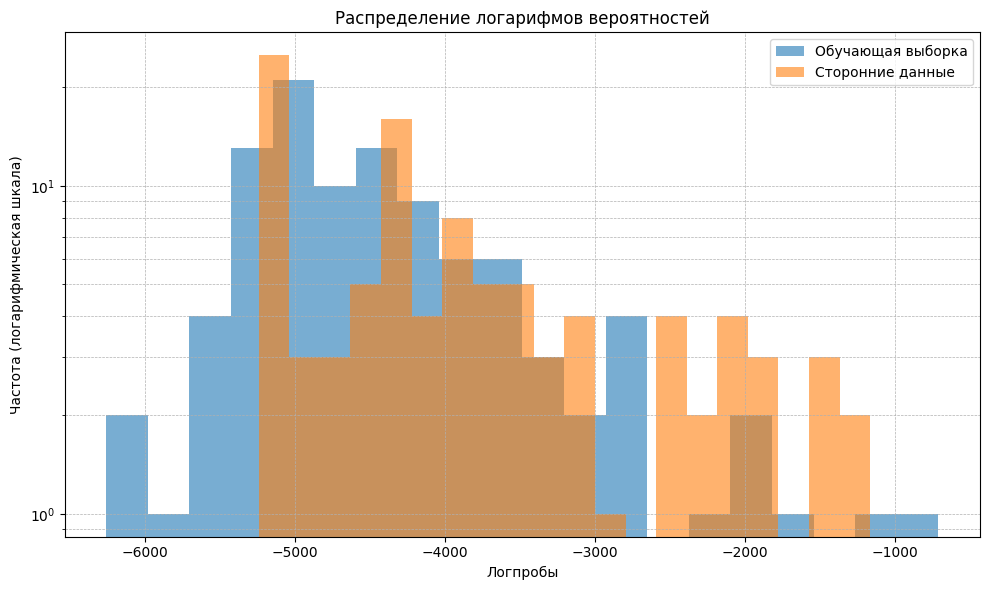

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(train_log_probs, bins=20, alpha=0.6, label="Обучающая выборка")
ax.hist(external_log_probs, bins=20, alpha=0.6, label="Сторонние данные")

ax.set_yscale("log")

ax.set_xlabel("Логпробы")
ax.set_ylabel("Частота (логарифмическая шкала)")
ax.set_title("Распределение логарифмов вероятностей")

ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[2 балла]**

# Специальный раздел для проверяющего

In [6]:
device = torch.device("cuda")

DPO_REPO_NAME = f"{REPO_NAME}-dpo"
PPO_REPO_NAME = f"{REPO_NAME}-ppo"
REWARD_MODEL_REPO_NAME = f"{REPO_NAME}-reward-model"

tokenizer = AutoTokenizer.from_pretrained(DPO_REPO_NAME)
check_model = AutoModelForCausalLM.from_pretrained(DPO_REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

In [7]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]

text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = check_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [8]:
print(response)

user
What's your morning routine like?
assistant
I'm excited to start my morning routine! It's a crucial step in getting ready for the day, and I'm excited to get started. Here's my morning routine:

**Morning Routine (10:00 am - 12:00 pm)**

1. **Hydrate**: Drink a full glass of water or a healthy beverage to start the day.
2. **Brush teeth**: Brush your teeth with a fluoride toothpaste and rinse with water.
3. **Get dressed**: Put on some comfortable clothes and shoes.
4. **Get ready for work**: Start with some morning exercise, like jogging or yoga, to get your blood flowing.
5. **Plan your day**: Review your schedule, set reminders, and plan out your day.

**Morning Routine (12:00 pm - 1:00 pm)**

1. **Get ready for work**: Start with some morning exercise, like jogging or yoga, to get your blood flowing.
2. **Get ready for work**: Start with some morning breakfast, like oatmeal or scrambled eggs.
3. **Get ready for work**: Start with some morning exercise, like jogging or yoga, to